In [2608]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from category_encoders import BinaryEncoder
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from datetime import datetime, timedelta

# Part 1 - Exploratory Data Analysis

In [2609]:
#reading in the logins file and converting to a dataframe
login_df= pd.read_json(r"logins.json")

In [2610]:
login_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [2611]:
#since the only information we have is the login time, converting to a time series will throw an error without another
#column of information, lets create a second column and populate it with 1 to avoid this.
login_df['check'] = 1

In [2612]:
login_df.head()

,login_time,check
0,1970-01-01 20:13:18,1
1,1970-01-01 20:16:10,1
2,1970-01-01 20:16:37,1
3,1970-01-01 20:16:36,1
4,1970-01-01 20:26:21,1


In [2613]:
login_df.shape

(93142, 2)

In [2614]:
#converting the login time column to datatime object
login_df['login_time'] = pd.to_datetime(login_df['login_time'])

In [2615]:
login_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
 1   check       93142 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.4 MB


In [2616]:
#groups the login time by 15 minute intervals
login_df_groupby_15 = pd.DataFrame(login_df.groupby([pd.Grouper(key='login_time', freq='15Min')]).sum()).reset_index()

In [2617]:
login_df_groupby_15

,login_time,check
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1
...,...,...
9783,1970-04-13 17:45:00,5
9784,1970-04-13 18:00:00,5
9785,1970-04-13 18:15:00,2
9786,1970-04-13 18:30:00,7


<Axes: xlabel='login_time'>

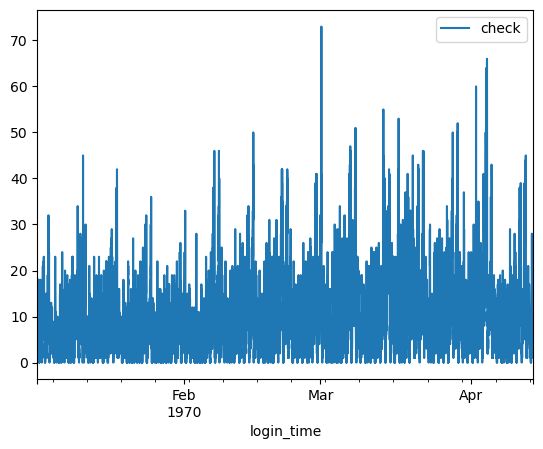

In [2618]:
#plot the time series of the newly grouped 15minute interval login counts
login_df_groupby_15.set_index('login_time').plot()

The time series does show a relatively consistent pattern through the days of the months, it seems to trend up and down based on the time of the day. The day/night cycle would be the best way to explain why logins fluctuates so consistently; however, we will need to take a closer look to confirm our hypothesis. Lets zoom in on the time series.

In [2619]:
#Instead of grouping the time series by 15minutes we will group them by 24hrs
login_df_groupby_24 = pd.DataFrame(login_df.groupby([pd.Grouper(key='login_time', freq='24H')]).sum()).reset_index()

<Axes: xlabel='login_time'>

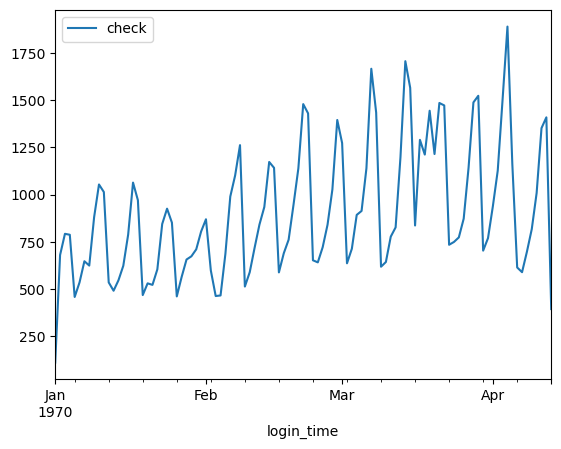

In [2620]:
login_df_groupby_24.set_index('login_time').plot()

After grouping the logins by 24hrs instead of 15 minutes, we've removed a lot of the noises shown in the previous time series. In this graph, we can see the lines spike up at the start of x-axis tick and then falling signicantly by the next x-axis tick. Given that the ticks are spaced into 4 we can use each tick to represent the first, second, third, and fourth week of the month. So perhaps instead of the pattern being based on the day/night cycle its based off on the time of the week. Lets see how which of the 15-minute interval logins had the largest login counts.

In [2621]:
#Sort by the highest check counts (the logins) and sorting from highest to lowest, display the top 20
login_df_time = login_df_groupby_15.sort_values(by='check', ascending=False).head(20)
login_df_time

,login_time,check
5602,1970-03-01 04:30:00,73
8870,1970-04-04 05:30:00,66
8854,1970-04-04 01:30:00,64
8853,1970-04-04 01:15:00,63
8654,1970-04-01 23:30:00,60
8868,1970-04-04 05:00:00,60
8867,1970-04-04 04:45:00,59
8869,1970-04-04 05:15:00,59
8855,1970-04-04 01:45:00,56
6825,1970-03-13 22:15:00,55


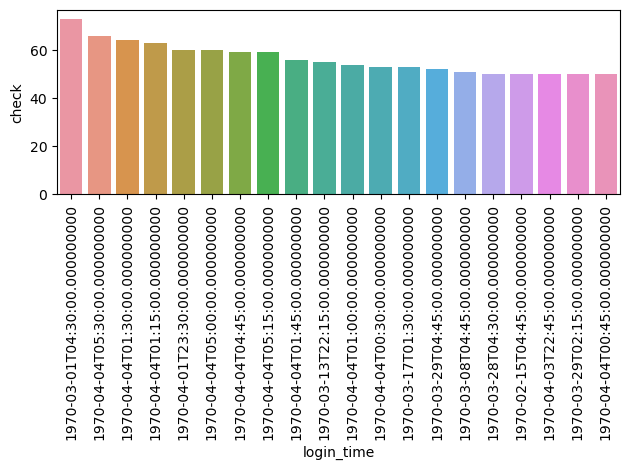

In [2622]:
#Visualize the top 20 logins
sns.barplot(data=login_df_time, x="login_time", y='check')
plt.xticks(rotation=90)
plt.tight_layout()

As seen in the plot above, April seemed to the most popular month for the logins, as the month took up 12 of the top 20 slots and all of them took place on either April 1st or April 4th. Additionally, all of the times on the on the top 20 shows the logins occuring late at evening or very early in the morning. The "earliest" login occuring at 22:15 and the "lastest" occuring at 05:30. Thus, the data indicates the login spikes at the start of the week, peaking at the middle of the week, and then declines. The pattern repeats at the start of the next week. The data also shows that the most popular time of the logins are done at noctural hours. 

In [2623]:
login_df_time = login_df_groupby_24.sort_values(by='check', ascending=False).head(20)
login_df_time

,login_time,check
93,1970-04-04,1889
72,1970-03-14,1706
65,1970-03-07,1666
73,1970-03-15,1565
87,1970-03-29,1523
92,1970-04-03,1504
86,1970-03-28,1488
79,1970-03-21,1485
51,1970-02-21,1479
80,1970-03-22,1472


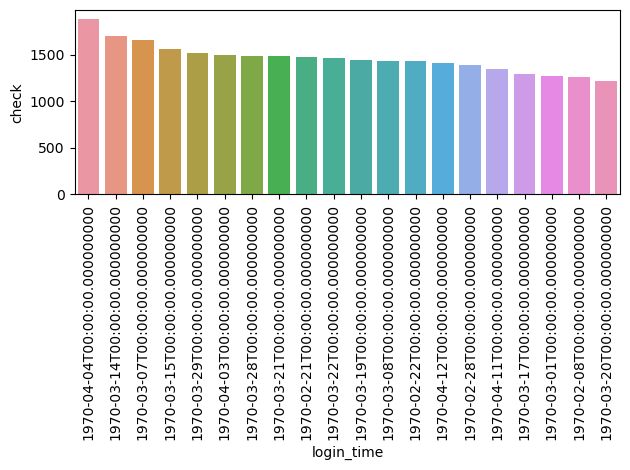

In [2624]:
sns.barplot(data=login_df_time, x="login_time", y='check')
plt.xticks(rotation=90)
plt.tight_layout()

# Part 2 ‐ Experiment and metrics design

1. What would you choose as the key measure of success of this experiment in
    encouraging driver partners to serve both cities, and why would you choose this metric?
    
    I would use the number of drivers passing through the toll bridge since that should be a relatively simple metric to keep track of for the city officials. If the number of drivers passing through the toll bridge sees an overall increase during the weekends it would be considered a success given the unique circadian rhythms of both cities. If the cities gives reimbursments to the driver partners, we can also measure the total revenue from the tolls. The total amount from the revenue from the proposed change should be higher than the previous revenue; however, the same cannot be said after the profits generated. There would have already been driver partners crossing the toll bridge before the reimbursment changes, so after the changes we should see a slight decline in profit. 

2) Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:

a) how you will implement the experiment
The experiment will be conducted using data on the toll bridge from before the toll reimbursment changes and the data collected after a few months or even years after the changes. We would of course need both sources of data to be used as comparsion for the revenue generated and the number of drivers passing through toll bridge. We could also keep track of the number of drivers who are partners or normal drivers, since this will be a requirement to get reimbursment. If the overall of driving partners increased from either cities then the proposed changes is a success; but of course, we would like to see an increase in normal drivers as well to boost the revenue from the toll bridge. 

b) what statistical test(s) you will conduct to verify the significance of the observation
The main statistical test that will be used will be the T-test to measure the drivers passing through the toll bridge over the course of a set time. The T-test will be used to determine if there is a signifcant difference between the drivers passing through the bridge before and after the reimbursment changes. The null hypothesis would be that there is an increase in driving partners passing through the toll bridge, and the alternative hypothesis would see the number of drivers passing through the toll bridge decrease. 

c) how you would interpret the results and provide recommendations to the city operations team along with any caveats
The results would need to come from the number of driving partners passing through the toll bridge and whether or not the null hypothesis is statified. We would also need to make sure the toll bridge generates a net positive profit to help maintain the bridge as increased usage of the toll bridge would require more maintenance as well. 

# Part 3 ‐ Predictive modeling

In [2625]:
#read in the project file and convert to dataframe
data_df = pd.read_json(r"ultimate_data_challenge.json")

In [2626]:
data_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [2627]:
data_df['signup_date'] = pd.to_datetime(data_df['signup_date'])

First, we need to create a target feature for our machine model to predict. A user is considered to be retained if they have used the platform once in the last month, six months after their initial sign-up date. So we will create a temprorary column that contains the data five months after the user's sign update date. We will then use that five month date to compare to the last trip the user took. 

In [2628]:
#Create column for date 5 months after signup date to use as comparsion
data_df["5_months_after_signup"] = data_df["signup_date"] + timedelta(5*30)

In [2629]:
data_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,5_months_after_signup
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,2014-06-24
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,2014-06-28
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,2014-06-05
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,2014-06-09
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,2014-06-26


Now we create the target column, of the last_trip_date greater than the 5_months_after_signup date, then the user is considered to be retained "1", else the user is not retained "0".

In [2630]:
#Create target column, compares date to determine whether or not a user is retained
data_df['is_retained'] = np.where((data_df['last_trip_date'] >= data_df['5_months_after_signup']), 1, 0)

In [2631]:
data_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,5_months_after_signup,is_retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,2014-06-24,0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,2014-06-28,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,2014-06-05,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,2014-06-09,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,2014-06-26,0


In [2632]:
#We can delete the temporary column since the target column has been created
data_df.drop("5_months_after_signup", axis=1, inplace=True)

# EDA

<Axes: >

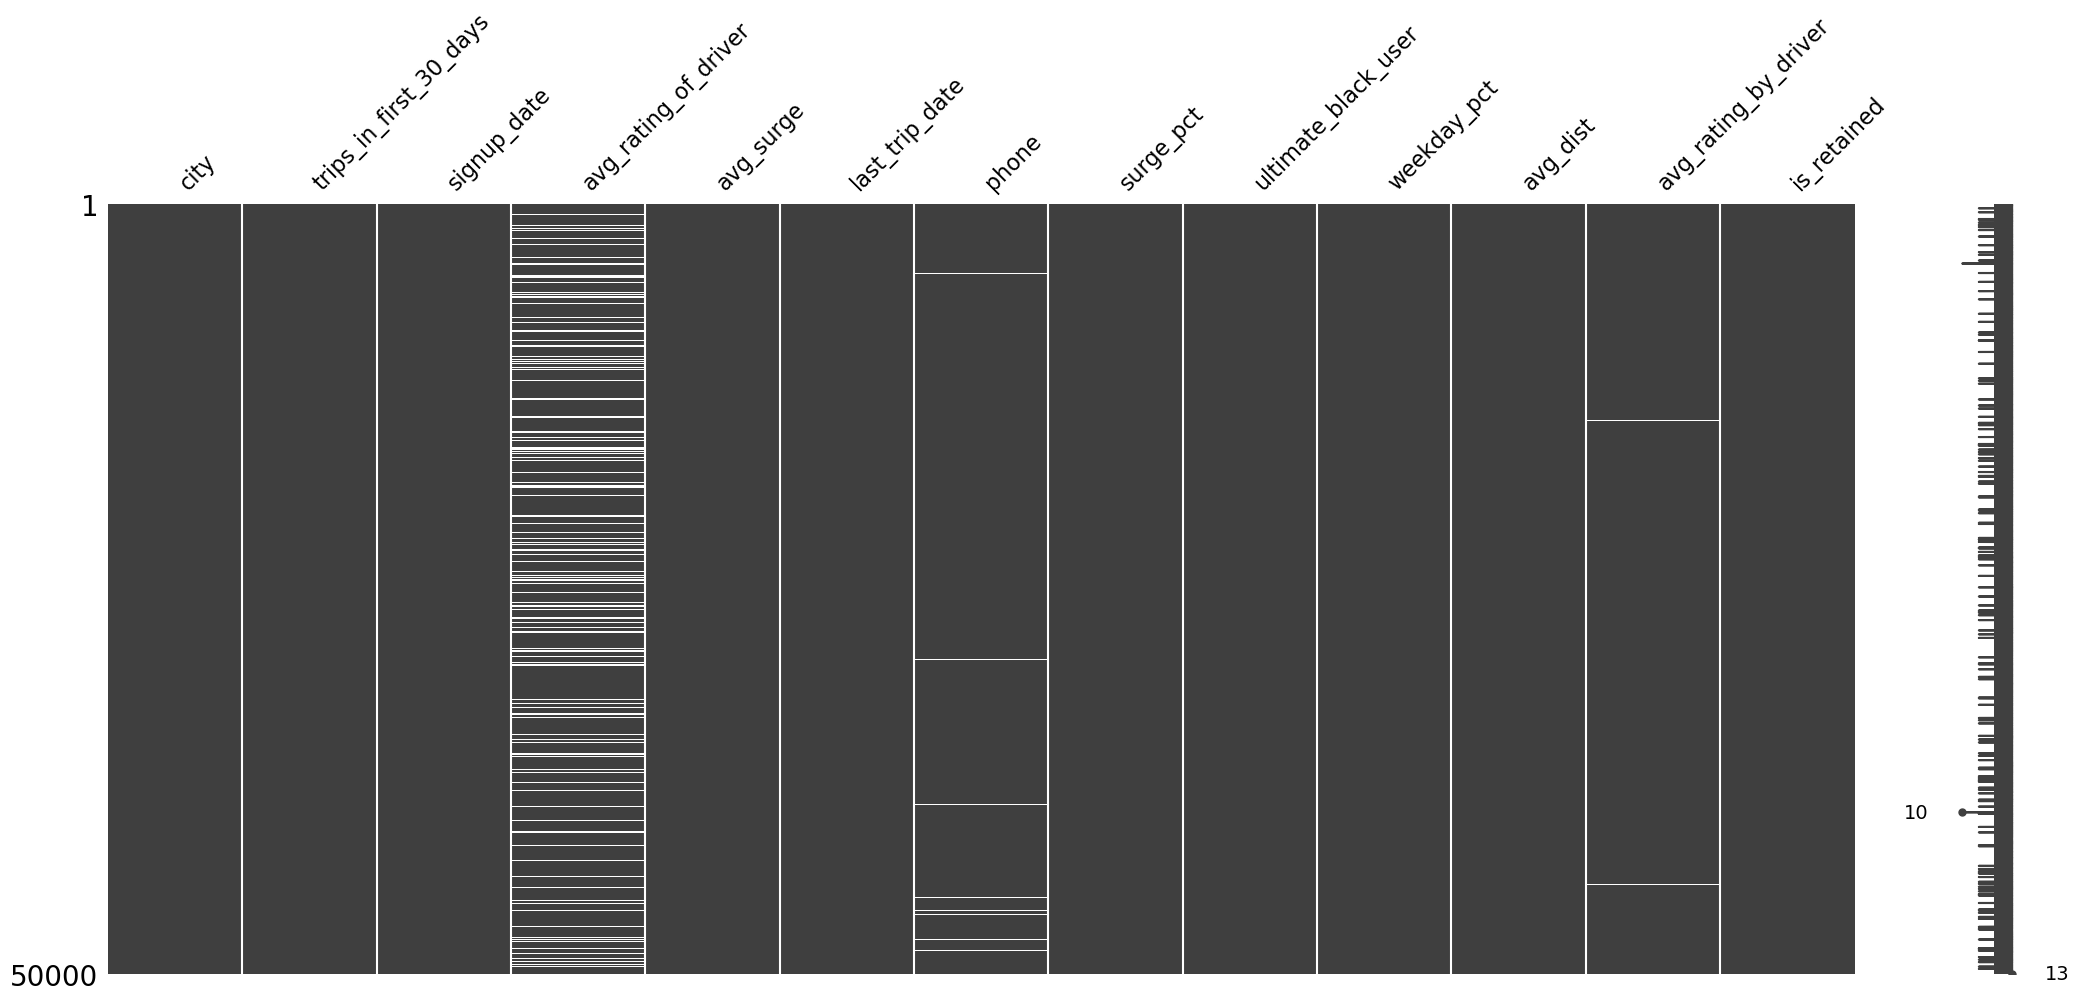

In [2633]:
#Lets check for any columns with missing data
msno.matrix(data_df)

Looks like the avg_rating_of_driver column has quite a significant percentage of missing data, the avg_rating_by_driver and phone feature also has missing data but not a significant amount. Lets replace the missing data of the avg_rating columns by the average of their own respective columns. 

For the phone column, lets look at the distribution of the users' phone brand. 

In [2634]:
# Sums up the total number of each phone types
phone_dist = data_df['phone'].value_counts()
keys=phone_dist.unique()
data=phone_dist.value_counts()

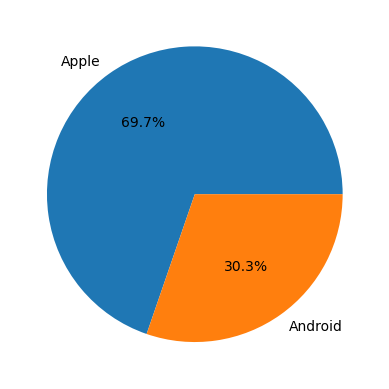

In [2635]:
# Visualize the phone type distribution
plt.pie(data_df['phone'].value_counts(), labels=['Apple', 'Android'], autopct='%1.1f%%')
plt.show()

It looks like Apple has the majority of the users' phone share. We will just replace the missing values of the phone column with "Apple" since there is not too many missing data (less than 10 rows) to cause a shift in data.

In [2636]:
#Fill in missing phone data with "Apple"
data_df['phone'].fillna("Apple" , inplace=True) 

<Axes: >

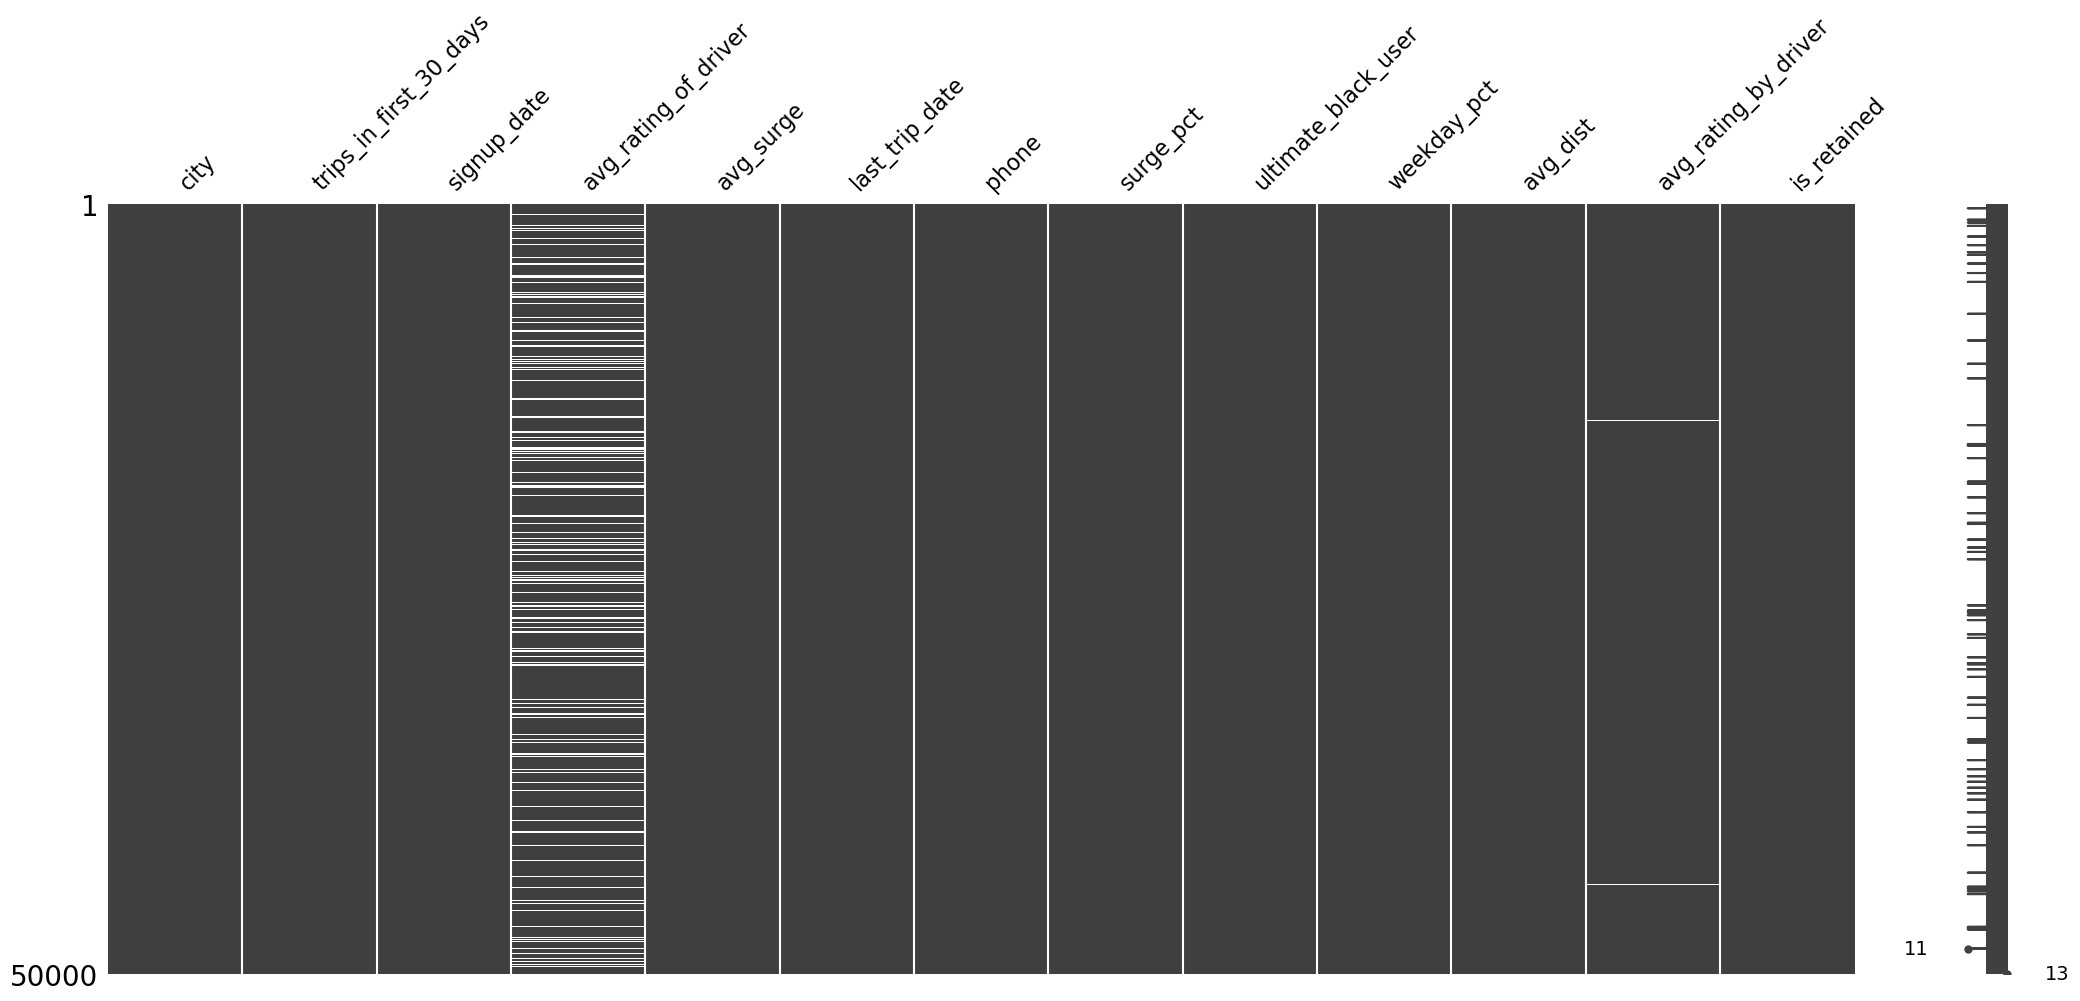

In [2637]:
msno.matrix(data_df)

In [2638]:
temp_df = data_df.copy(deep=True)
temp_df.dropna(axis='rows', inplace=True)

In [2639]:
#Imputating the average rating features by the average of their respectively columns
data_df['avg_rating_of_driver'] = data_df['avg_rating_of_driver'].fillna(data_df['avg_rating_of_driver'].median())
data_df['avg_rating_by_driver'] = data_df['avg_rating_by_driver'].fillna(data_df['avg_rating_by_driver'].median())

<Axes: >

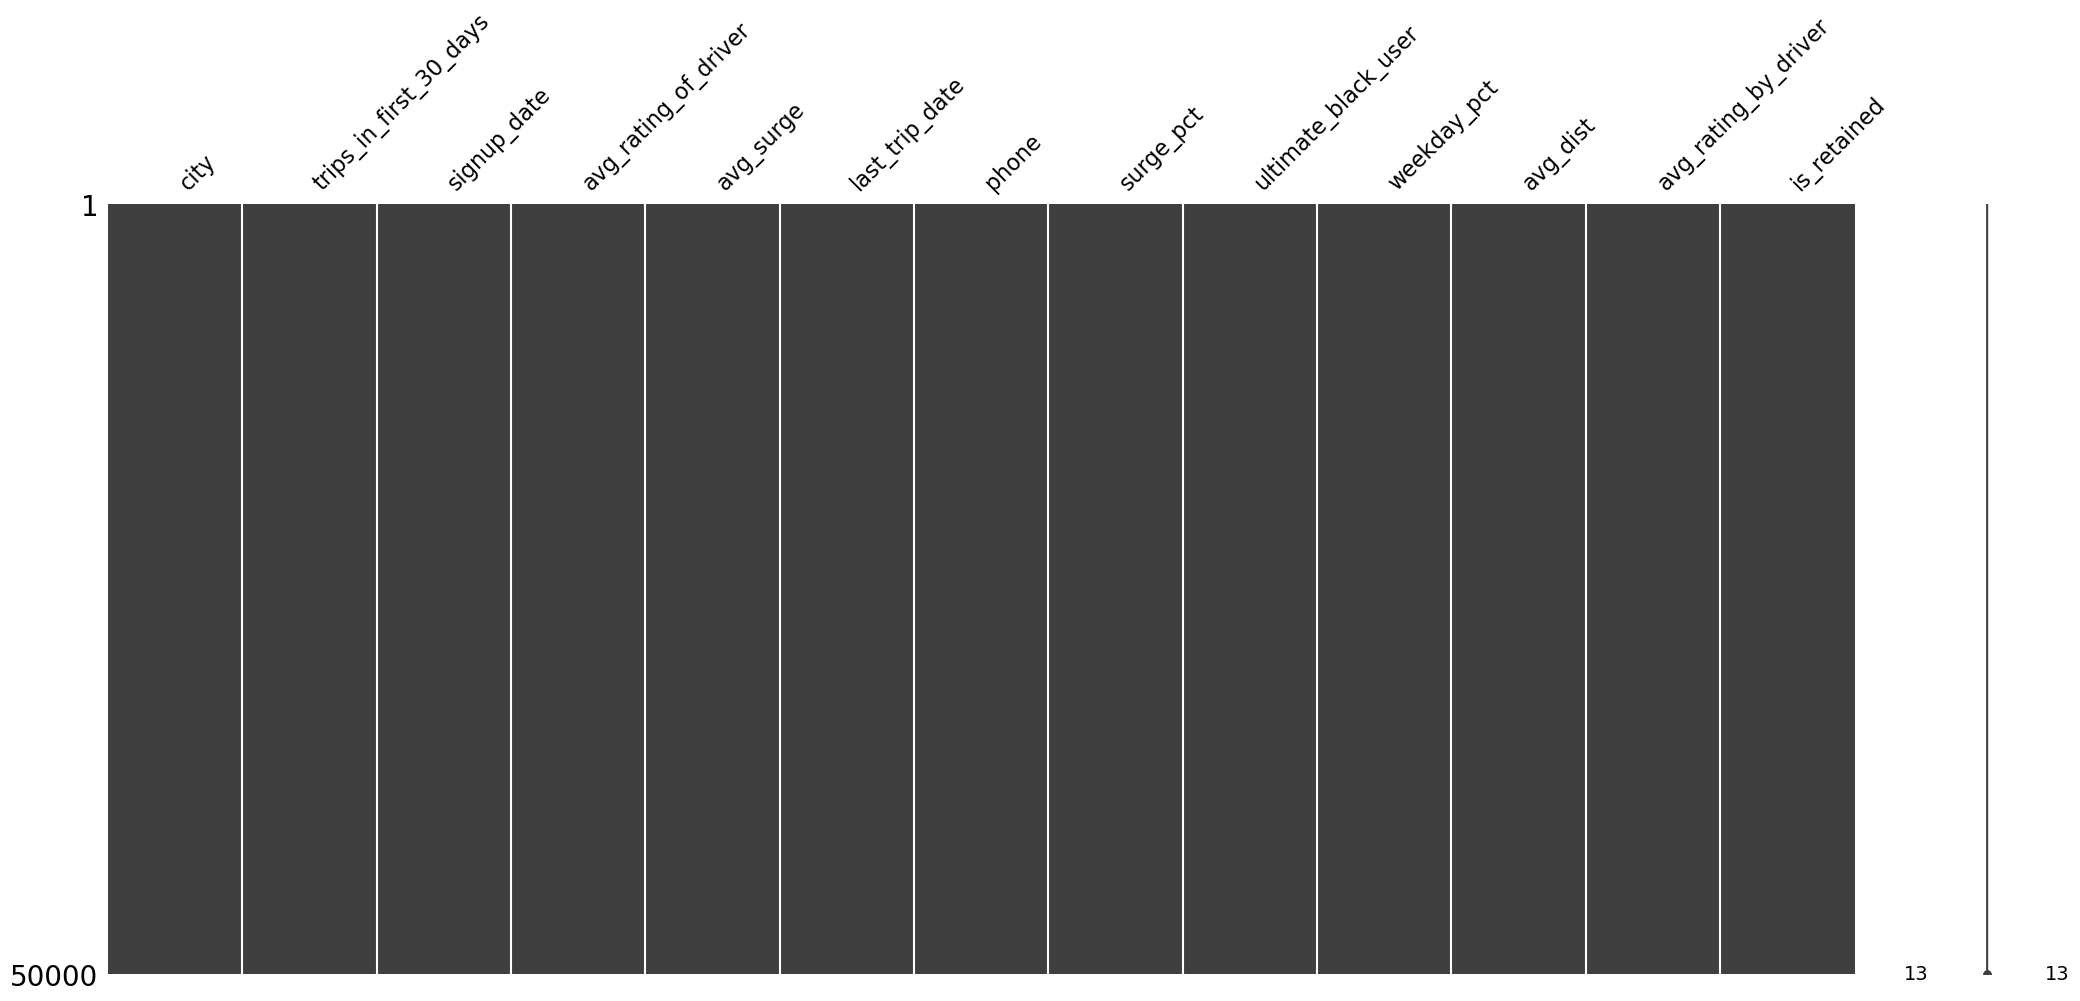

In [2640]:
msno.matrix(data_df)

Looks like the all of the missing data has been filled in.

In [2641]:
temp_df['avg_rating_of_driver'].describe()

count    41744.000000
mean         4.601801
std          0.616079
min          1.000000
25%          4.300000
50%          4.900000
75%          5.000000
max          5.000000
Name: avg_rating_of_driver, dtype: float64

In [2642]:
data_df['avg_rating_of_driver'].describe()

count    50000.000000
mean         4.650038
std          0.575601
min          1.000000
25%          4.500000
50%          4.900000
75%          5.000000
max          5.000000
Name: avg_rating_of_driver, dtype: float64

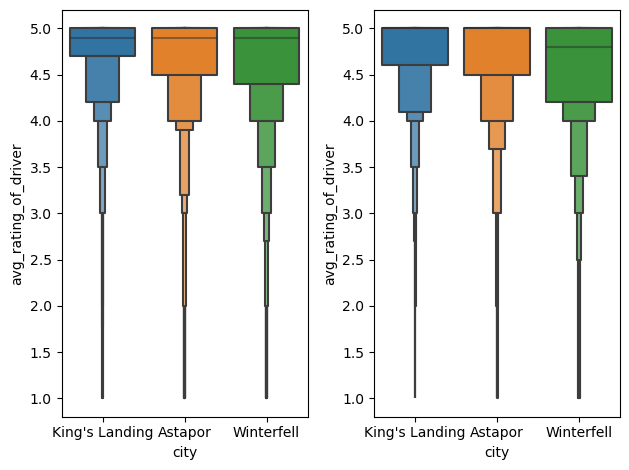

In [2643]:
fig, axes = plt.subplots(1, 2)

sns.boxenplot(data=data_df, x="city", y='avg_rating_of_driver', ax=axes[0])
sns.boxenplot(data=temp_df, x="city", y='avg_rating_of_driver', ax=axes[1])
fig.tight_layout()
plt.show()

Looks like filling in the missing date increased the mean rating overall, but it does seems to for every city as we can see Winterfell had a drop in their median. 

In [2644]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  object        
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
 12  is_retained             50000 non-null  int32 

Looks like all of the missing data has been imputed and resolved. Now lets look at our target feature, the "ultimate_black_user" column. The column is a boolean representation of whether or not the user is a retained user. Thus; this is a binary classification problem. 

In [2645]:
#Sum up all of the users as either True or False
data_df['is_retained'].value_counts()

0    37286
1    12714
Name: is_retained, dtype: int64

Looks like most users in this dataset falls under the category of False which is not retained, lets visualize this a little better.

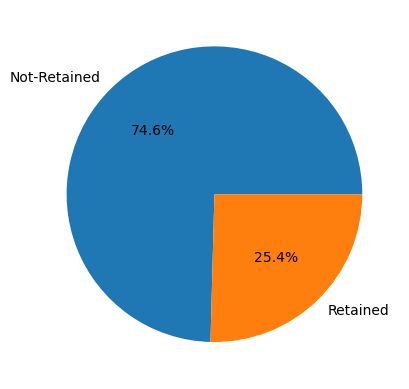

In [2646]:
#Create a visualization of the retained vs not-retained
plt.pie(data_df['is_retained'].value_counts(), labels=['Not-Retained', 'Retained'], autopct='%1.1f%%')
plt.show()

The data shows a majority of the user are not retained-users given the constraints provided to us. So just under 75% of the users are not regular users and a little over 25% are retained users.

In [2647]:
data_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,is_retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


Lets start preparing our data to feed into our machine learning model. We need to start by coverting our categorical features into numerical values since the algorithm only takes numerical values, we will achieve this through encoding. 

In [2648]:
data_df.shape

(50000, 13)

# Preprocessing

In [2649]:
#Performing dummy encoding on features with a low number of categorical values to reduce the number of new columns
#we create, these three features only have 2 categories so the coding with create binary representation essentially.
cols_to_dummy = ["ultimate_black_user"]
prefix = cols_to_dummy[:]
data_df = pd.get_dummies(data_df, prefix=prefix, prefix_sep='_', columns=cols_to_dummy, drop_first=True)

In [2650]:
#Rename the target column name
data_df.rename(columns={'ultimate_black_user_True':'ultimate_black_user'}, inplace=True)

In [2651]:
#Extract the year, month, and day value form the signup_date column give them their own column
data_df['sign_up_year'] = pd.to_datetime(data_df['signup_date']).dt.year
data_df['sign_up_month'] = pd.to_datetime(data_df['signup_date']).dt.month
data_df['sign_up_day'] = pd.to_datetime(data_df['signup_date']).dt.day

In [2652]:
#Extract the year, month, and day value form the last_trip_date column give them their own column
data_df['last_trip_year'] = pd.to_datetime(data_df['last_trip_date']).dt.year
data_df['last_trip_month'] = pd.to_datetime(data_df['last_trip_date']).dt.month
data_df['last_trip_day'] = pd.to_datetime(data_df['last_trip_date']).dt.day

In [2653]:
#Drop these two columns since they're duplicate data now
data_df.drop(['signup_date', 'last_trip_date'], axis=1, inplace=True)

In [2654]:
data_df.columns

Index(['city', 'trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'phone', 'surge_pct', 'weekday_pct', 'avg_dist', 'avg_rating_by_driver',
       'is_retained', 'ultimate_black_user', 'sign_up_year', 'sign_up_month',
       'sign_up_day', 'last_trip_year', 'last_trip_month', 'last_trip_day'],
      dtype='object')

In [2655]:
#Here we will do our second encoding, we will use  


encoder = LabelEncoder()
data_df["city"] = encoder.fit_transform(data_df["city"])
data_df["phone"] = encoder.fit_transform(data_df["phone"])

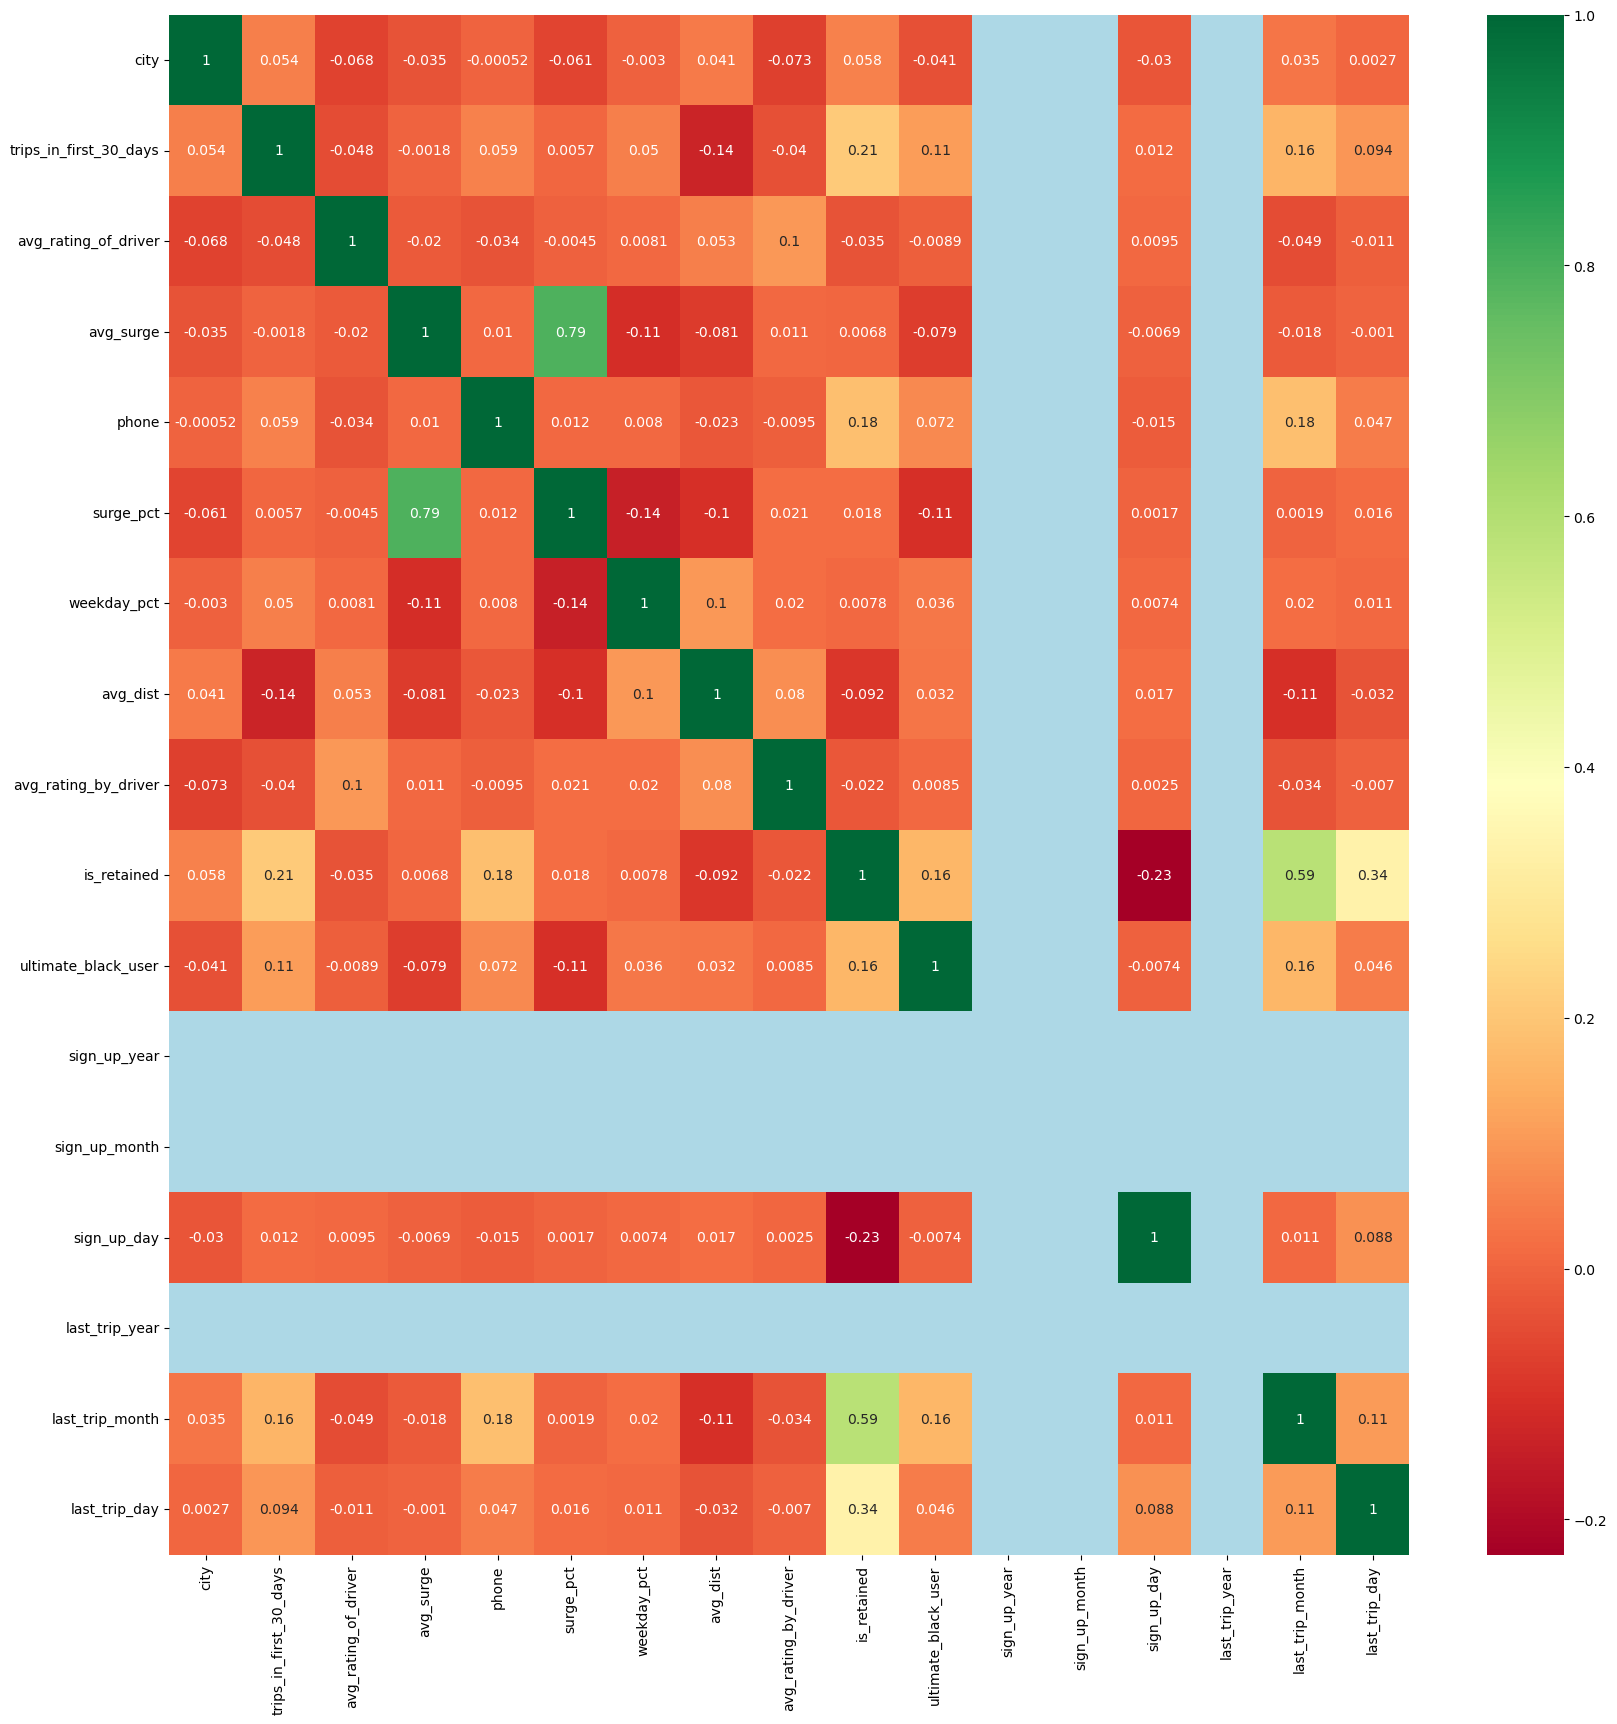

In [2656]:
#Lets create a heat map to check for any features that could be a strong predictor for the target variable
corrmat = data_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
color = plt.get_cmap('RdYlGn')   # default color
color.set_bad('lightblue') 
g=sns.heatmap(data_df[top_corr_features].corr(),annot=True,cmap=color)

According to the heat map, the feature with the highest correlation to the "is_retained" target is "last_trip_month" and "last_trip_day" the second highest. The heat map seems to have a quite a significant amount of bad data, so lets confirm the findings with another method.

In [2657]:
#Splits into independent and dependent variables
X = data_df.drop(['is_retained'], axis=1)
y = data_df['is_retained']

[0.01417976 0.01476037 0.01242387 0.00982083 0.01925994 0.01352676
 0.02763789 0.01582358 0.01341    0.01463369 0.         0.
 0.13697778 0.         0.5174225  0.19012303]


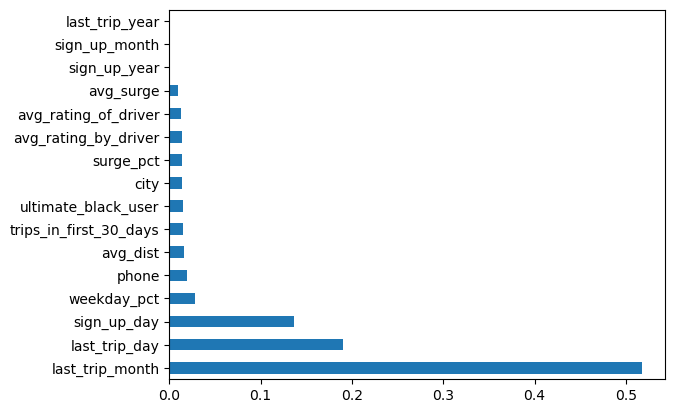

In [2658]:
#Create a ExtraTrees model to extract most important features from the model
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

It looks like the "last_trip_day" is most important feature for predicting where a user is retained or not. The second most important feature is "last_trip day" and the third most important is "sign_up_day". 

In [2659]:
X

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,ultimate_black_user,sign_up_year,sign_up_month,sign_up_day,last_trip_year,last_trip_month,last_trip_day
0,1,4,4.7,1.10,2,15.4,46.2,3.67,5.0,1,2014,1,25,2014,6,17
1,0,0,5.0,1.00,0,0.0,50.0,8.26,5.0,0,2014,1,29,2014,5,5
2,0,3,4.3,1.00,2,0.0,100.0,0.77,5.0,0,2014,1,6,2014,1,7
3,1,9,4.6,1.14,2,20.0,80.0,2.36,4.9,1,2014,1,10,2014,6,29
4,2,14,4.4,1.19,0,11.8,82.4,3.13,4.9,0,2014,1,27,2014,3,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1,0,5.0,1.00,2,0.0,100.0,5.63,4.2,0,2014,1,25,2014,6,5
49996,0,1,4.9,1.00,2,0.0,0.0,0.00,4.0,0,2014,1,24,2014,1,25
49997,2,0,5.0,1.00,0,0.0,100.0,3.86,5.0,1,2014,1,31,2014,5,22
49998,0,2,3.0,1.00,2,0.0,100.0,4.58,3.5,0,2014,1,14,2014,1,15


In [2660]:
y

0        0
1        0
2        0
3        1
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: is_retained, Length: 50000, dtype: int32

In [2661]:
y.value_counts()

0    37286
1    12714
Name: is_retained, dtype: int64

In [2662]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [2663]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Lets create a base random forest model to begin the modelling step, this will give us a good baseline to determine how the preprocessing went. 

In [2664]:
base_rf_model = RandomForestClassifier()
base_rf_model.fit(X_train_scaled, y_train)
y_pred = base_rf_model.predict(X_test_scaled)
f1_score(y_pred, y_test)

0.9930706790734508

In [2665]:
k=5
scores = cross_val_score(base_rf_model, X_train, y_train, scoring='f1', cv = k)
scores

array([0.98967552, 0.9933612 , 0.99314062, 0.99117647, 0.99288344])

Cross validation yield similar scores as well. Lets see how tuning the hyperparamters will perform. 

In [2666]:
params_rf = {
          "criterion":['gini', 'log_loss'],
          "min_samples_split": [11000],
         "min_samples_leaf": [12000],
        "max_features": ['sqrt'],
          "max_depth":[1],
         "class_weight":["balanced","balanced_subsample"],
         "n_estimators":[500]
       }

The idea here is by performing 500 n_estimators we hope to avoid overfitting as the more trees we have the less likely the model is to overfit.

In [2667]:
rf_model = RandomForestClassifier()

random_search_rf = RandomizedSearchCV(rf_model, param_distributions=params_rf, n_jobs=6, verbose=True)
random_search_rf.fit(X_train_scaled, y_train)

C:\Users\Ching\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 4 candidates, totalling 20 fits


RandomizedSearchCV(estimator=RandomForestClassifier(), n_jobs=6,
                   param_distributions={'class_weight': ['balanced',
                                                         'balanced_subsample'],
                                        'criterion': ['gini', 'log_loss'],
                                        'max_depth': [1],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [12000],
                                        'min_samples_split': [11000],
                                        'n_estimators': [500]},
                   verbose=True)

In [2668]:
rf_probs = random_search_rf.predict_proba(X_test_scaled)

In [2669]:
rf_probs = rf_probs[:, 1]

In [2670]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

ns_probs = [0 for _ in range(len(y_test))]

ns_auc = roc_auc_score(y_test, ns_probs)
rf_auc = roc_auc_score(y_test, rf_probs)
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Random Forest: ROC AUC=%.3f' % (rf_auc))

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.847


In [2671]:
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)

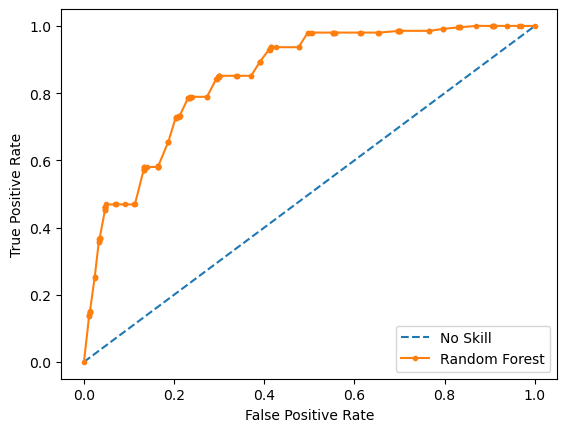

Random Forest: ROC AUC=0.847


In [2672]:
#Plot the ROC AUC
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()
print('Random Forest: ROC AUC=%.3f' % (rf_auc))

From the predictions of this model, we can see that it has an ROC curve score of 0.847 which is a good score. While I worry about the model potentially overfitting, we have taken steps to mitigate it by performing cross validation. Farther steps included tuning hyperparamters such as increasing the n_estimators, decreasing the max depth, increase the min-leaf-sample and min-leaf-split. Understanding what the ROC metric means is it is a trade-off between  true-positive (correctly idenntified) rate vs negative-positive (falsely-identified) rates. So a high score essentially means the model will more likely identify correctly.

The stakeholders at Ultimate can use this predictive model to determine whether or not a user be ratained at a relatively high accuracy. The model can be modified to use data collected a few months after the user has signed up instead of six months if Ultimate is more urgent to determine whether or not the user will be retained. 